In [19]:
import numpy as np
import matplotlib.pyplot as plt
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)

# Dynamic Pricing using Bandits

## The demand curve

### **Assumptions**: I am the only one selling this item (monopoly), I have infinite availability, and $n_t$ customers show up at day $t$.
## Also: we only sell one product (no competition between alternative products)
## In this phase, we run the pricing algorithm independently from the auction one, so the number of customers arriving at each day is fixed

### Single customer:

In [20]:
price = 0.4
min_price = 0
max_price = 1


def changing_x(t):
    tau = 50.0
    """# we change value of x every tau time steps
    t = t // tau # integer division"""
    t = t / tau
    t -= np.pi # just to make it start at 0
    x = np.sin(t)# we will consider a noise in the third part of the project, the extension of pricing + np.random.normal(0,0.5)
    return (x+1)/4 # bounded between 0 and 0.5


conversion_probability = lambda p,t: 1 - np.exp(p/max_price - 1)/2 - changing_x(t)  # expected demand curve in terms of probability of purchase
# test at time 0
t0 = 0

sold = np.random.binomial(1, conversion_probability(price, t0)) #  binomial(1) = bernoulli

print(f'Probability of purchase at price {price}: {conversion_probability(price, t0)}')

# will the customer buy my product at this price?
print(f'Sold? {bool(sold)}')

Probability of purchase at price 0.4: 0.47559418195298675
Sold? False


### let's plot the conversion probability for a fixed price to see how it changes over time

Text(0, 0.5, 'Probability of purchase')

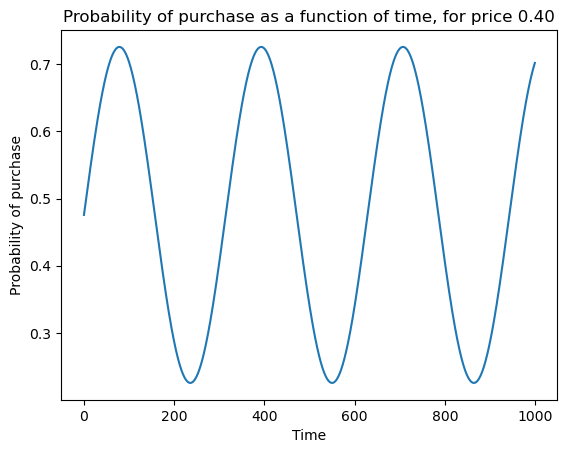

In [21]:
T = 1000
t_interval = range(T)

probabilities = [conversion_probability(price, t) for t in t_interval]
plt.plot(t_interval, probabilities)
plt.title('Probability of purchase as a function of time, for price %.2f' % price)
plt.xlabel('Time')
plt.ylabel('Probability of purchase')

### Multiple customers:

In [22]:
from Configuration import N_USERS # fixed value; the more customers we have, the more the estimate will converge to the true probability

sales = np.random.binomial(N_USERS, conversion_probability(price, t0))

# will the customer buy my product at this price?
print(f'How many sales? {sales}')

How many sales? 7


### Expectation over multiple customers:

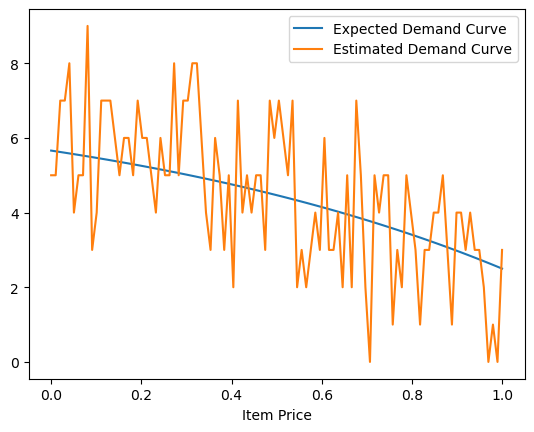

In [23]:
prices = np.linspace(min_price, max_price, 100)
t0=0
expected_demand_curve = N_USERS*conversion_probability(prices, t0)

estimated_demand_curve = np.random.binomial(N_USERS, conversion_probability(prices, t0))

plt.figure()
plt.plot(prices, expected_demand_curve, label='Expected Demand Curve')
plt.plot(prices, estimated_demand_curve, label='Estimated Demand Curve')
plt.xlabel('Item Price')
plt.legend()
plt.show();

### How is the demand curve changing over time?

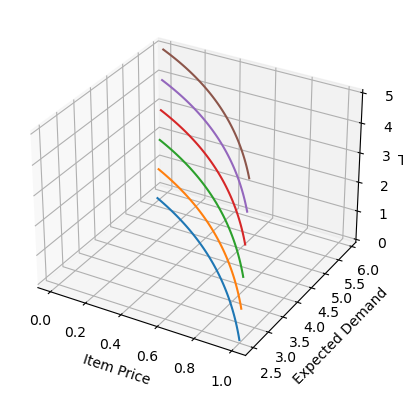

In [24]:
t_interval = np.linspace(0,5,6)

# lets plot the demand curve in a 3D plot to observe the evolution of the demand curve over time
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for t in t_interval:
    expected_demand_curve = N_USERS*conversion_probability(prices, t)
    ax.plot(prices, expected_demand_curve, t)

ax.set_xlabel('Item Price')
ax.set_ylabel('Expected Demand')
ax.set_zlabel('Time')
plt.show()

### How can I compute my profit?

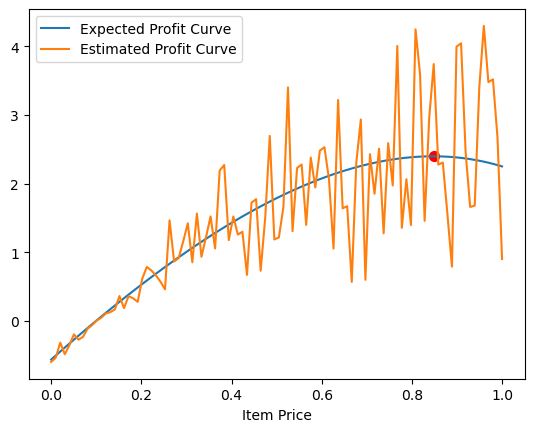

In [25]:
cost = 0.1

expected_profit_curve = N_USERS*conversion_probability(prices, t0)*(prices-cost)

estimated_profit_curve = np.random.binomial(N_USERS, conversion_probability(prices, t0))*(prices-cost)

best_price_index = np.argmax(expected_profit_curve)
best_price = prices[best_price_index]

plt.figure()
plt.plot(prices, expected_profit_curve, label='Expected Profit Curve')
plt.plot(prices, estimated_profit_curve, label='Estimated Profit Curve')
plt.scatter(best_price, expected_profit_curve[best_price_index], color='red', s=50)
plt.xlabel('Item Price')
plt.legend()
plt.show();

## let's see how the profit curve changes over time

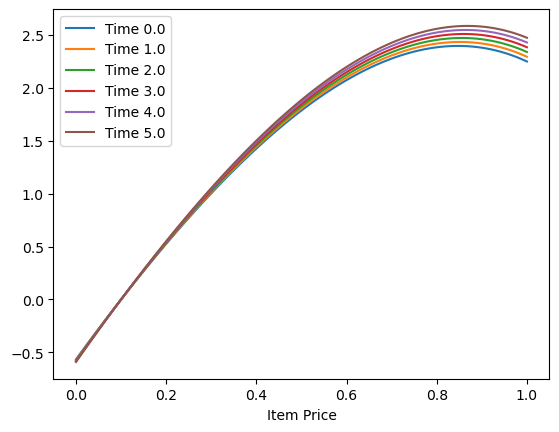

In [26]:
# let's plot the profit curves for different times
t_interval = np.linspace(0,5,6)


for t in t_interval:
    expected_profit_curve = N_USERS*conversion_probability(prices, t)*(prices-cost)
    plt.plot(prices, expected_profit_curve, label=f'Time {t}')

plt.xlabel('Item Price')
plt.legend()
plt.show()

### How can I find the better price, while maximizing my cumulative profits? -> Exploration-Exploitation trade-off -> Online Learning!
## bandit problem!

### Let's formalize the environment:

In [27]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.conversion_probability = conversion_probability
        self.cost = cost
        

    def round(self, p_t, n_t, t): #n_t is the numebr of customers at time t, p_t is the price at time t
        d_t = np.random.binomial(n_t, self.conversion_probability(p_t, t)) #demand at time t
        r_t = (p_t - self.cost)*d_t #reward at time t
        return d_t, r_t    

In [28]:
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
env.round(0.86, N_USERS, t0)

(2, 1.52)

### Warning: this is the number of sales, not the profit!

### Extra: try to modify the environment to allow for seed fixing, in order to make the simulations entirely reproducible, i.e., generate all the rewards sequences a priori

In [29]:
class PricingEnvironment:
    def __init__(self, conversion_probability, cost):
        self.generator = np.random.default_rng(RANDOM_SEED)
        self.conversion_probability = conversion_probability
        self.cost = cost
        

    def round(self, p_t, n_t, t): #n_t is the numebr of customers at time t, p_t is the price at time t
        d_t = self.generator.binomial(n_t, self.conversion_probability(p_t, t)) #demand at time t
        r_t = (p_t - self.cost)*d_t #reward at time t
        return d_t, r_t    

In [31]:
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
env.round(0.86, N_USERS, t0)

(4, 3.04)

## Naive Approach: Discretization

### Idea: I partition possible prices in a discrete number, then use a standard MAB algorithm such as UCB1

In [32]:
class UCB1Agent:
    def __init__(self, K, T, range=1):
        self.K = K
        self.T = T
        self.range = range
        self.a_t = None
        self.average_rewards = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.t = 0
    
    def pull_arm(self):
        if self.t < self.K:
            self.a_t = self.t 
        else:
            ucbs = self.average_rewards + self.range*np.sqrt(2*np.log(self.T)/self.N_pulls)
            self.a_t = np.argmax(ucbs)
        return self.a_t
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.average_rewards[self.a_t] += (r_t - self.average_rewards[self.a_t])/self.N_pulls[self.a_t]
        self.t += 1

### I use a standard MAB agent with a **very** large number of actions

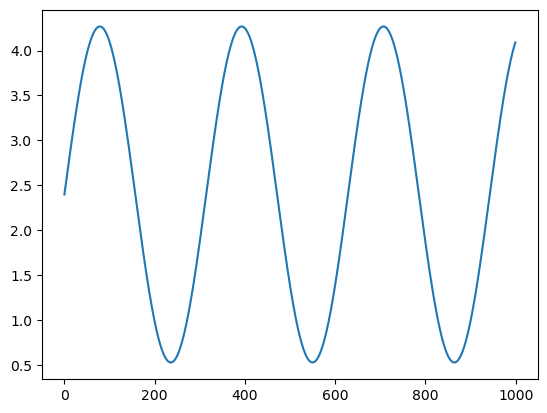

In [33]:
T = 1000 # try T=100, why this behavior?
K = 100
t_interval = range(T)

prices = np.linspace(min_price, max_price,K) # 100 actions!

n_customers = N_USERS # I assume the number of customers arriving is the same everyday (for now, in general this is not true)

reward_function = lambda price, n_sales: (price-cost)*n_sales  # profit curve
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

# let's compute the clairvoyant
# at first let's compute an array of profit curves for each time
profit_curve = lambda t: reward_function(prices, n_customers*conversion_probability(prices, t))
# the baseline for an adversarial MAB is the reward obtained by the best FIXED action
rewards = np.array([profit_curve(t) for t in t_interval])
total_rewards = np.sum(rewards, axis=0)
best_price_index = np.argmax(total_rewards)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = rewards[:, best_price_index]

plt.figure()
plt.plot(t_interval, expected_clairvoyant_rewards, label='Expected Clairvoyant Reward')

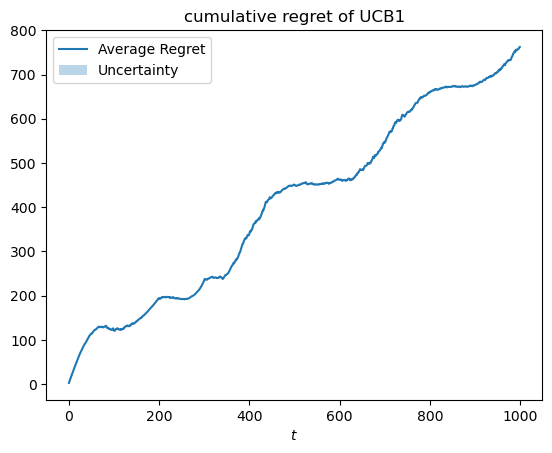

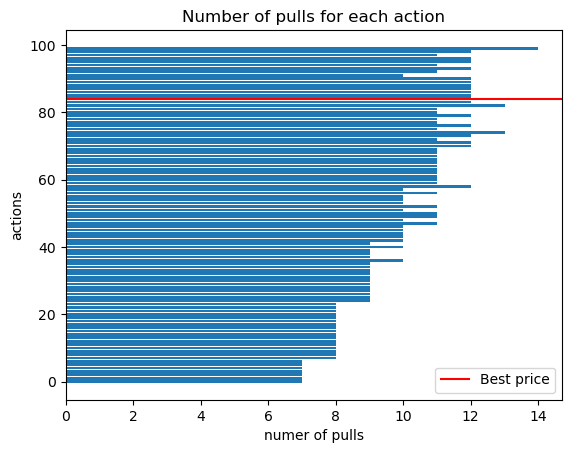

In [34]:
n_trials = 100

regret_per_trial = []

for seed in range(n_trials):
    np.random.seed(seed)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)
    ucb_agent = UCB1Agent(K, T, range=maximum_profit)

    agent_rewards = np.array([])

    for t in range(T):
        pi_t = ucb_agent.pull_arm() ## the agent returns the index!!
        p_t = prices[pi_t] # I get the actual price
        d_t, r_t = env.round(p_t, n_customers, t)
        ucb_agent.update(r_t)

        agent_rewards = np.append(agent_rewards, r_t)

    cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)
    regret_per_trial.append(cumulative_regret)

regret_per_trial = np.array(regret_per_trial)

average_regret = regret_per_trial.mean(axis=0)
regret_sd = regret_per_trial.std(axis=0)

plt.plot(np.arange(T), average_regret, label='Average Regret')
plt.title('cumulative regret of UCB1')
plt.fill_between(np.arange(T),
                average_regret-regret_sd/np.sqrt(n_trials),
                average_regret+regret_sd/np.sqrt(n_trials),
                alpha=0.3,
                label='Uncertainty')
#plt.plot((0,T-1), (average_regret[0], average_regret[-1]), 'ro', linestyle="--")
plt.xlabel('$t$')
plt.legend()
plt.show()

plt.figure()
plt.barh(np.arange(100), ucb_agent.N_pulls)
plt.axhline(best_price_index, color='red', label='Best price')
plt.ylabel('actions')
plt.xlabel('numer of pulls')
plt.legend()
plt.title('Number of pulls for each action')
plt.show();

Fitted exponent: 0.7178876818065393


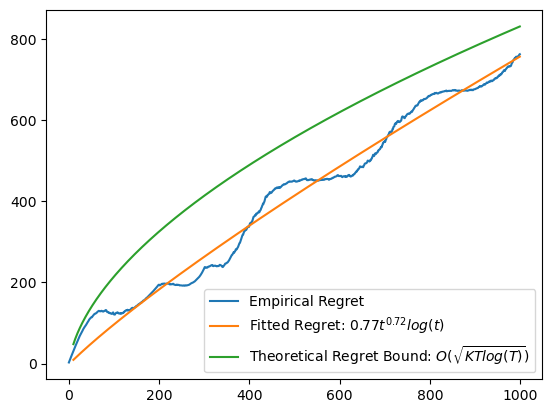

In [41]:
from scipy.optimize import curve_fit
fit_window = np.arange(10, T)
def model(x, a, b):
    return a*(x**b*(np.log(x)))

popt, pcov = curve_fit(model, fit_window, average_regret[fit_window])
ymodel = model(fit_window, *popt)
print('Fitted exponent:', popt[1])

fig, ax = plt.subplots()
ax.plot(np.arange(T), average_regret, label='Empirical Regret')
ax.plot(fit_window, ymodel, label='Fitted Regret: ${%.2f}t^{%.2f}log(t)$' % (popt[0], popt[1]))
max_regret_theoretical = lambda t: (K*t*np.log(t))**0.5
ax.plot(fit_window, max_regret_theoretical(fit_window), label='Theoretical Regret Bound: $O(\sqrt{KTlog(T)})$')
ax.legend()

sublinear, even if little

### This approach is often too naive, since the regret of MAB algorithms scales with $\sqrt{K}$!

$$ R_T \le \sqrt{KT \log(T)}$$
### K is very large in this case!! Important factor k!

# NOT NEEDED ---

## Bandits with Arm Structure

### Dynamic pricing is an example of bandit problem with additional structure. 

### In standard Multi-Armed Bandits, actions are assumed to be independent, and there is no structure among them. In pricing applications, it is customary to assume that similar prices will lead to similar outcomes, thus there is some sort of "smoothness" in the reward function. Moreover, actions naturally belong to an infinite set (even though prices can be discretized to the cent, such a large number can be considered infinite).

## Gaussian Processes

### key: model all the arms not as independent s variables, but as multivariate ones. While ucb1 considers (independent) bounds, and Thomson sampling uses alpha beta (independent) distributions, Gaussian processes use Multivariate Gaussian processes exploiting the information on near costs

### Gaussian Processes model a set of observations as multivariate normals.

### They rely on a _kernel_, that is an operator that quantifies the covariance between two samples. Using this covariance notion, we are able to estimate uncertainty simultaneously an all points. We will focus on one of the most common kernels: Radial Basis Function Kernel (RBF).

In [130]:
# use this in project, better than scikit learn one
class RBFGaussianProcess:
    def __init__(self, scale=1, reg=1e-2):
        self.scale = scale 
        self.reg = reg
        self.k_xx_inv = None

    def rbf_kernel_incr_inv(self, B, C, D):
        temp = np.linalg.inv(D - C @ self.k_xx_inv @ B)
        block1 = self.k_xx_inv + self.k_xx_inv @ B @ temp @ C @ self.k_xx_inv
        block2 = - self.k_xx_inv @ B @ temp
        block3 = - temp @ C @ self.k_xx_inv
        block4 = temp
        res1 = np.concatenate((block1, block2), axis=1)
        res2 = np.concatenate((block3, block4), axis=1)
        res = np.concatenate((res1, res2), axis=0)
        return res

    def rbf_kernel(self, a, b):
        a_ = a.reshape(-1, 1)
        b_ = b.reshape(-1, 1)
        output = -1 * np.ones((a_.shape[0], b_.shape[0]))
        for i in range(a_.shape[0]):
            output[i, :] = np.power(a_[i] - b_, 2).ravel()
        return np.exp(-self.scale * output)
    
    def fit(self, x=np.array([]), y=np.array([])):
        x,y = np.array(x),np.array(y)
        if self.k_xx_inv is None:
            self.y = y.reshape(-1,1)
            self.x = x.reshape(-1,1)
            k_xx = self.rbf_kernel(self.x, self.x) + self.reg * np.eye(self.x.shape[0])
            self.k_xx_inv = np.linalg.inv(k_xx)
        else:
            B = self.rbf_kernel(self.x, x)
            self.x = np.vstack((self.x, x))
            self.y = np.vstack((self.y, y))
            self.k_xx_inv = self.rbf_kernel_incr_inv(B, B.T, np.array([1 + self.reg]))

        return self

    def predict(self, x_predict):
        k = self.rbf_kernel(x_predict, self.x)

        mu_hat = k @ self.k_xx_inv @ self.y
        sigma_hat = 1 - np.diag(k @ self.k_xx_inv @ k.T)

        return mu_hat.ravel(), sigma_hat.ravel()

### For a reference on Gaussian Processes and Bandits see https://arxiv.org/pdf/1704.00445.pdf

### Given a set of (price, sales) observations, how can I use GPs to model the demand curve?

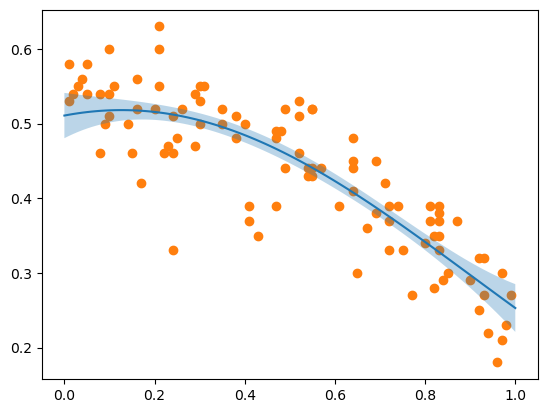

In [131]:
from Configuration import PRICES
price_samples = np.random.sample(size=100).round(2) # randomly generating prices

# GP works well if the samples are in [0,1], thus we normalize them
normalized_sales_samples = np.random.binomial(n_customers, conversion_probability(price_samples, t0))/n_customers

# Instantiate a Gaussian Process model, the scale is usually set of an order of magnitude below the order of magnitude of the range 
# prices in the range (0.1, 1) -> scale in the range (0.01, 0.1)
gp = RBFGaussianProcess(scale=1, reg=0.5)

gp.fit(price_samples, normalized_sales_samples)

mu, sigma = gp.predict(prices) # also get the uncertainty sigma, very useful for decision making

plt.figure()
plt.scatter(price_samples, normalized_sales_samples, color='C1')
plt.plot(PRICES, mu)
plt.fill_between(PRICES, mu-sigma, mu+sigma, alpha=0.3)
plt.show();

### Sequential Update:

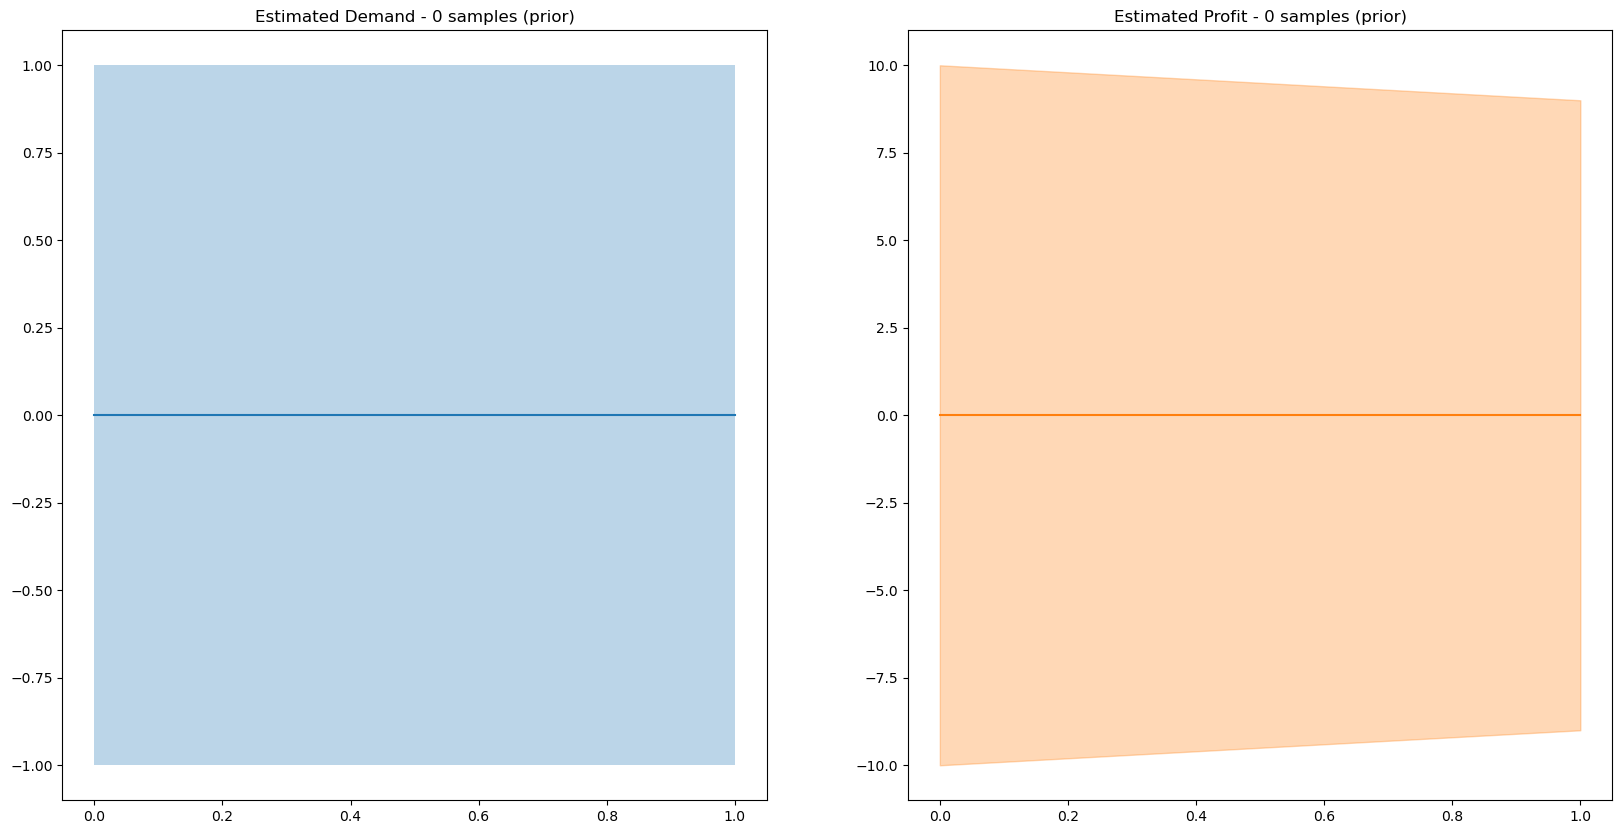

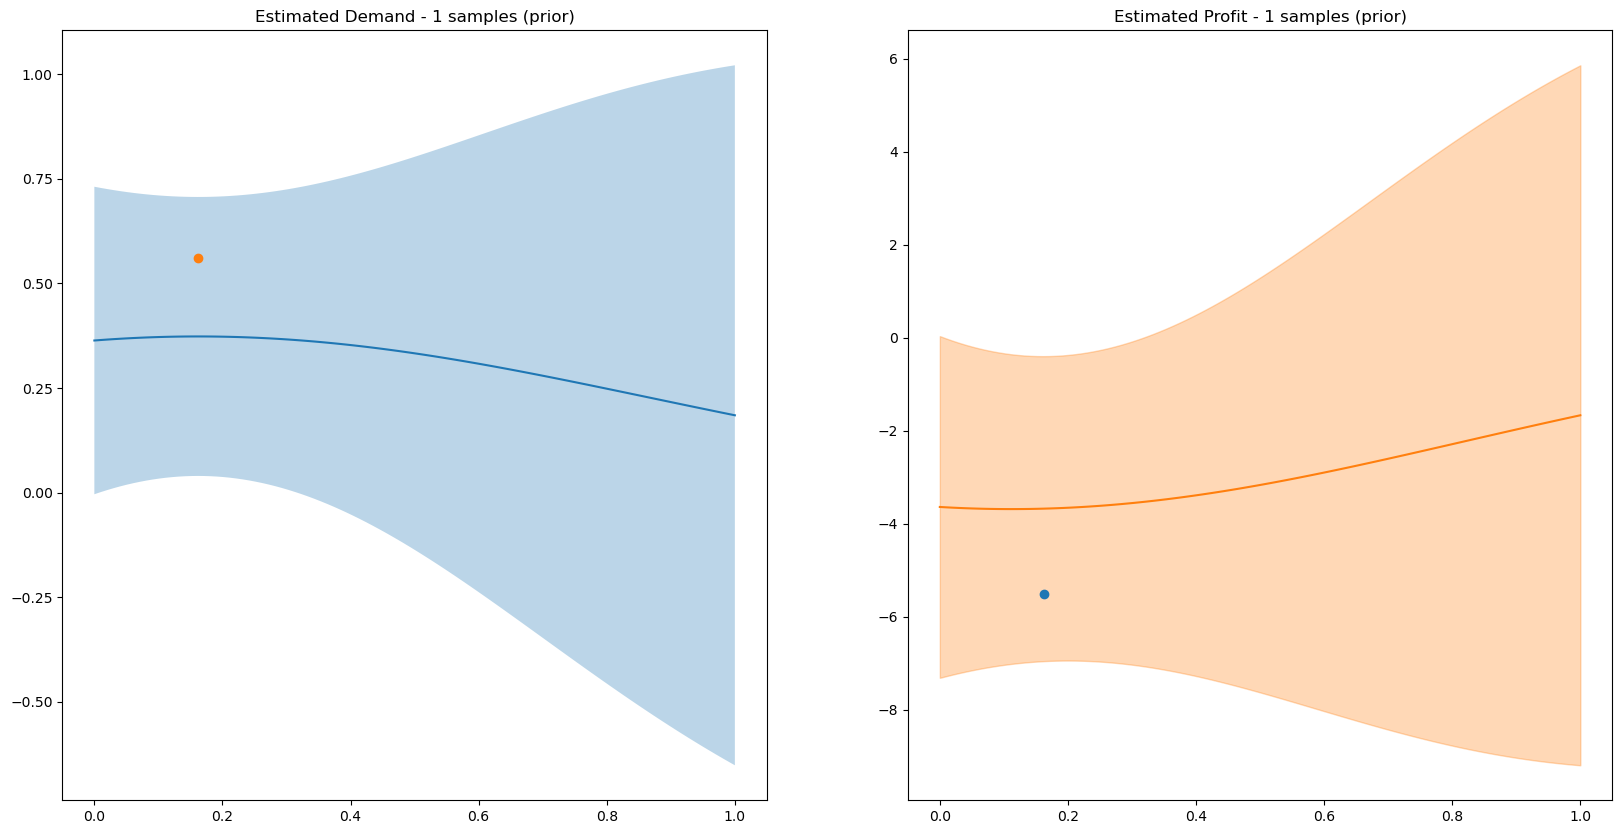

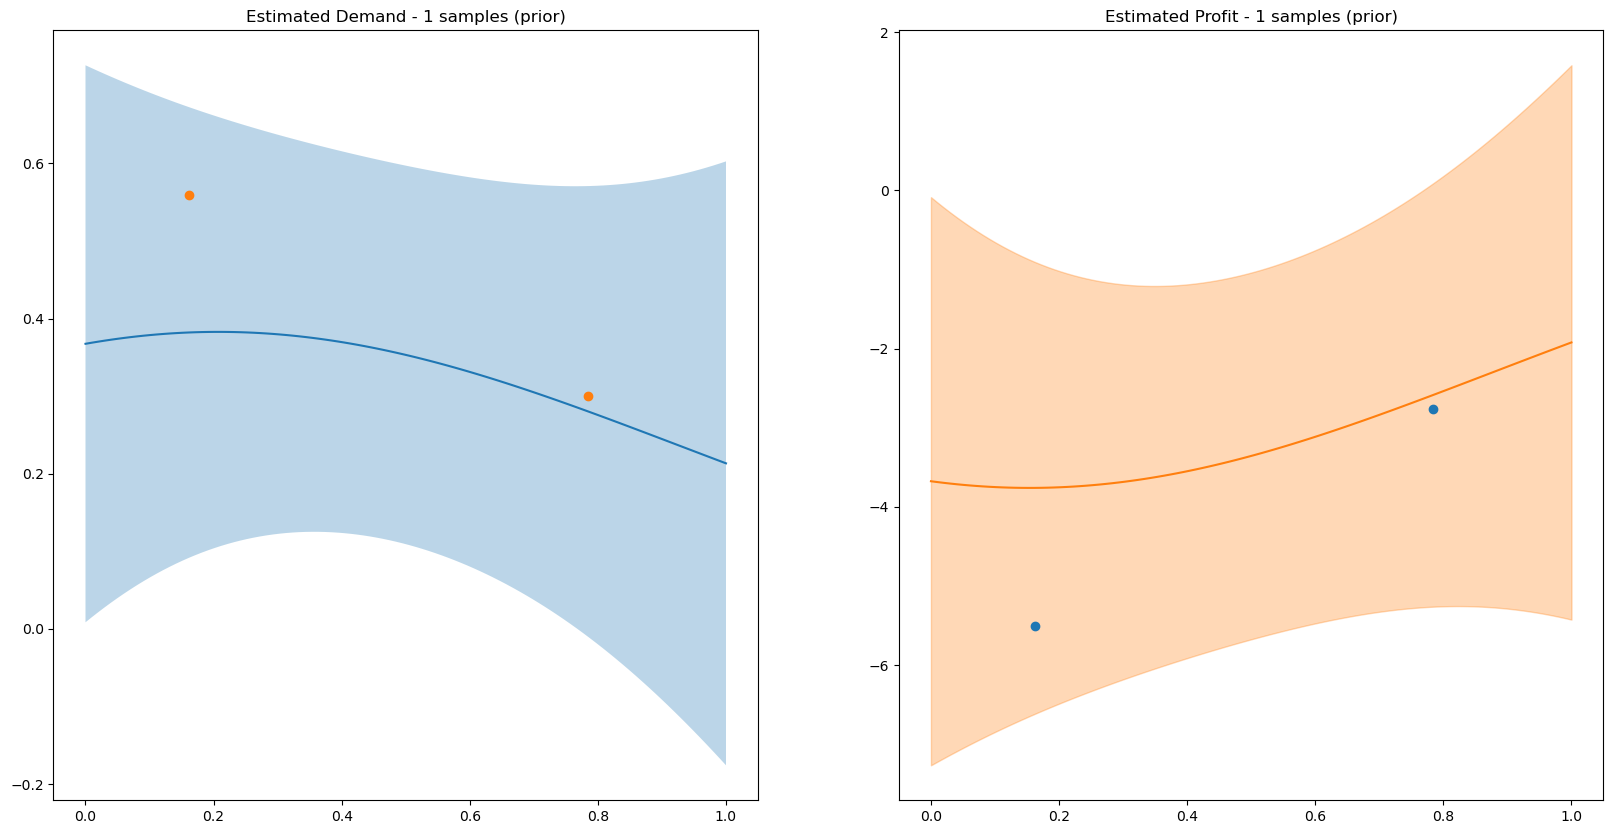

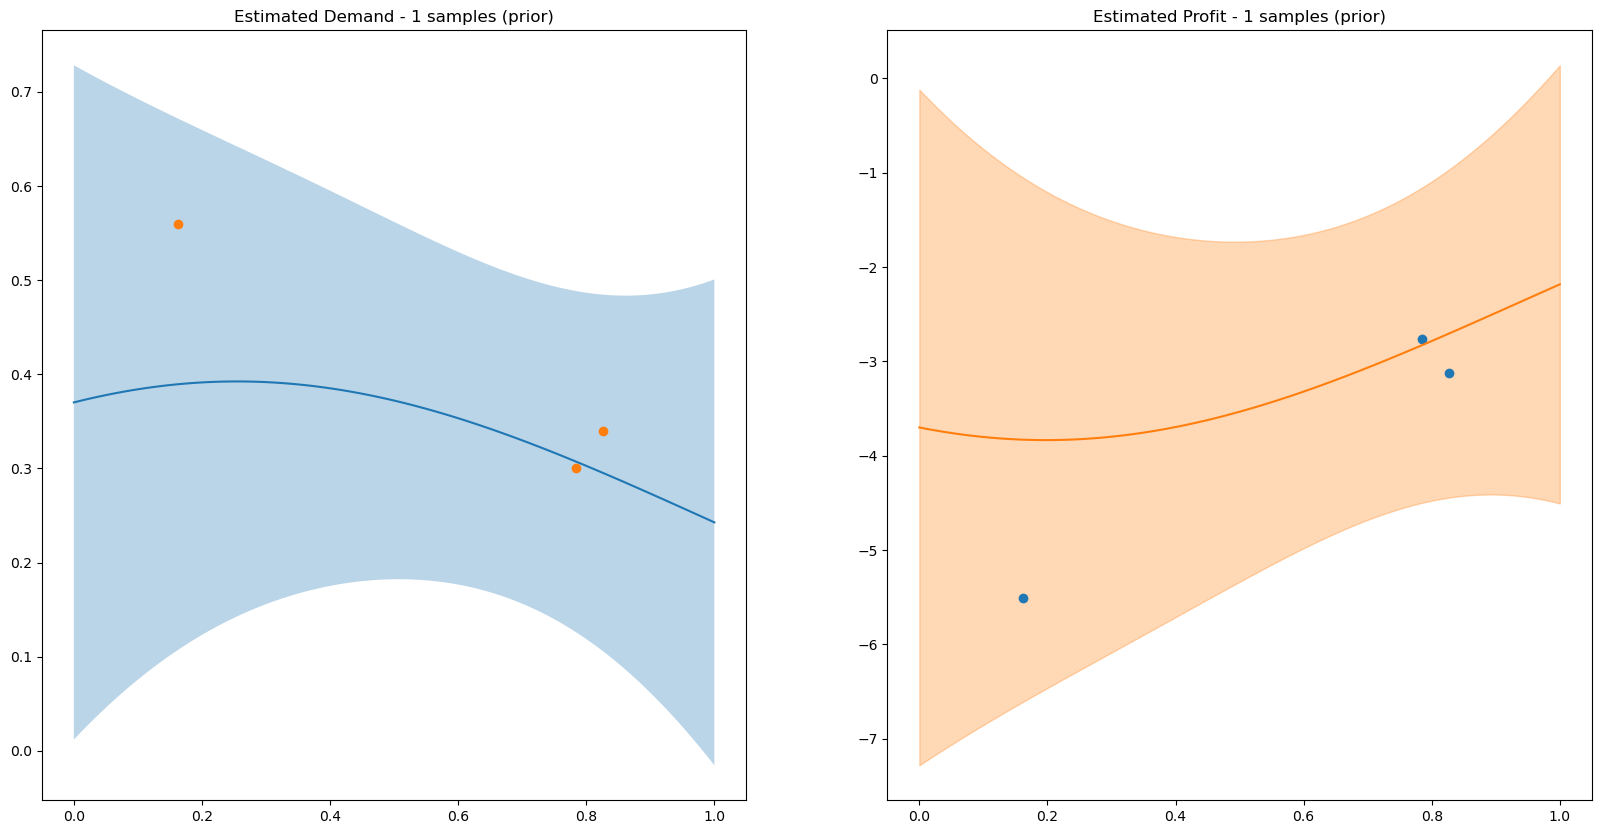

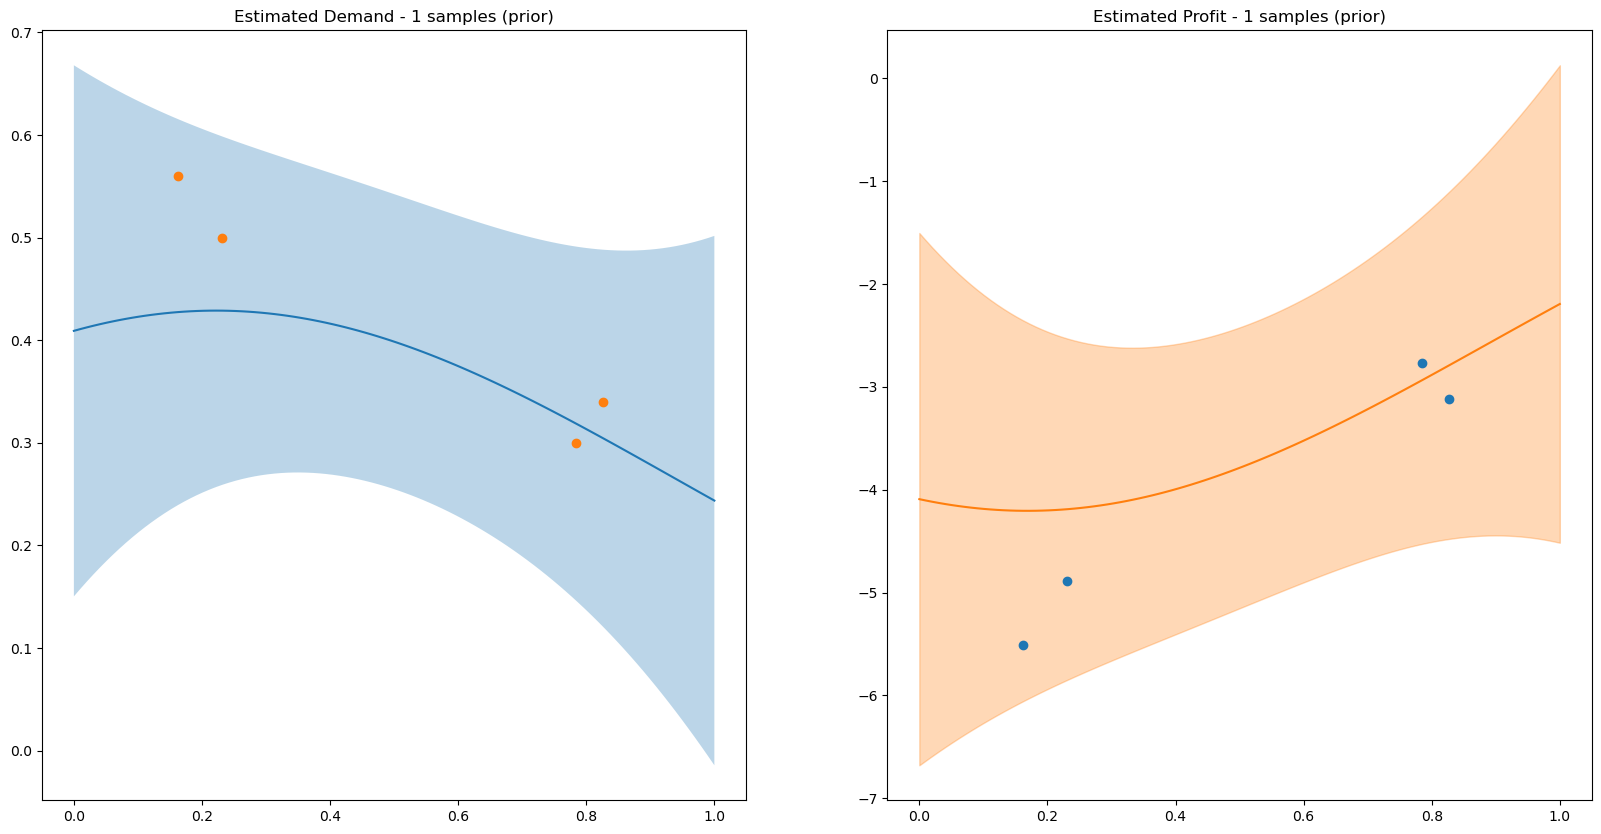

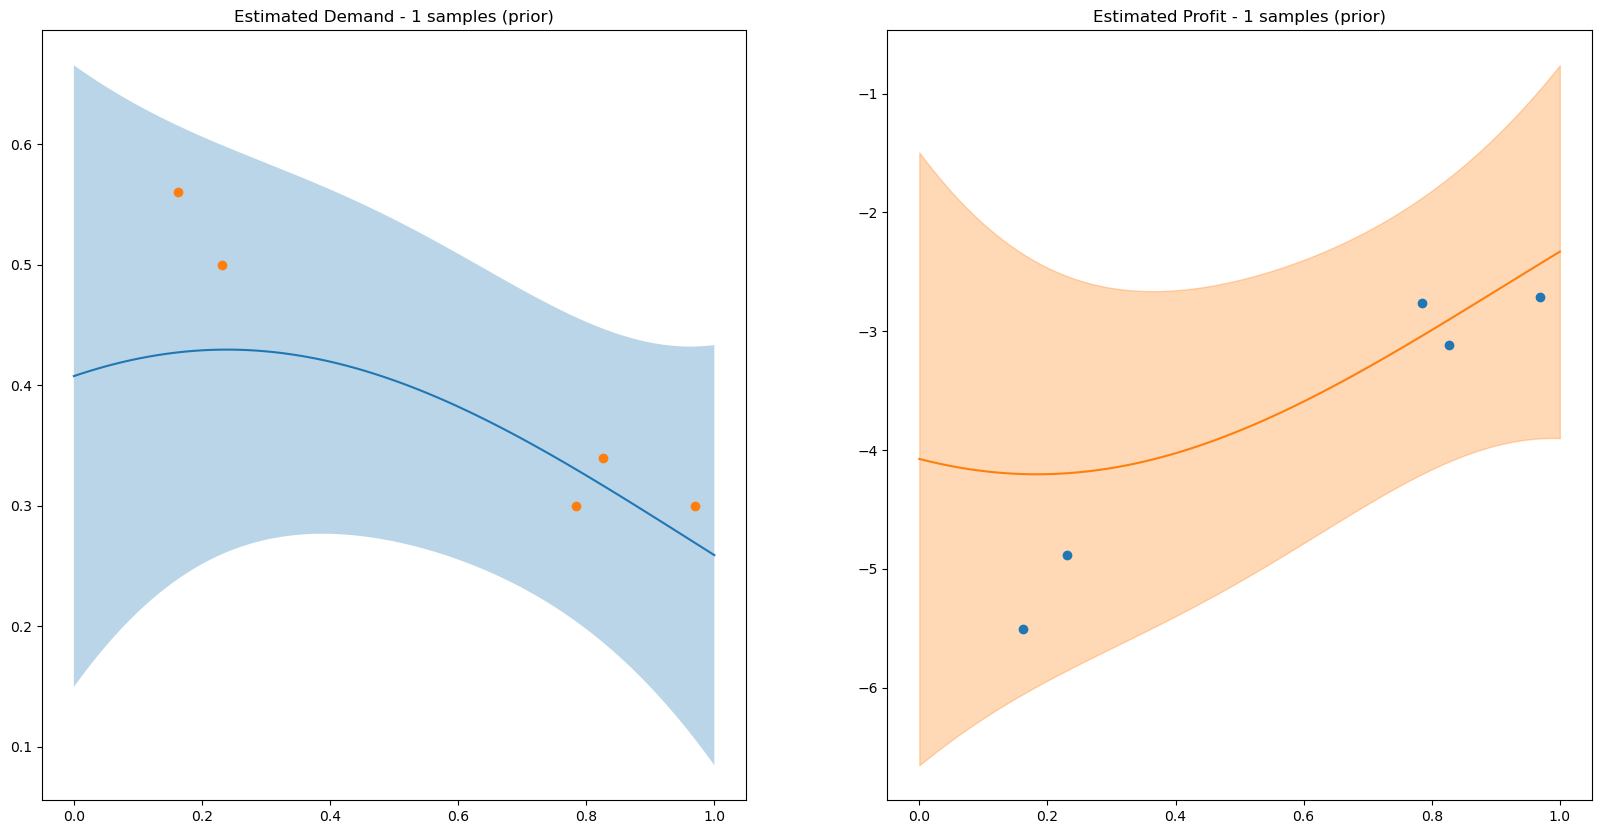

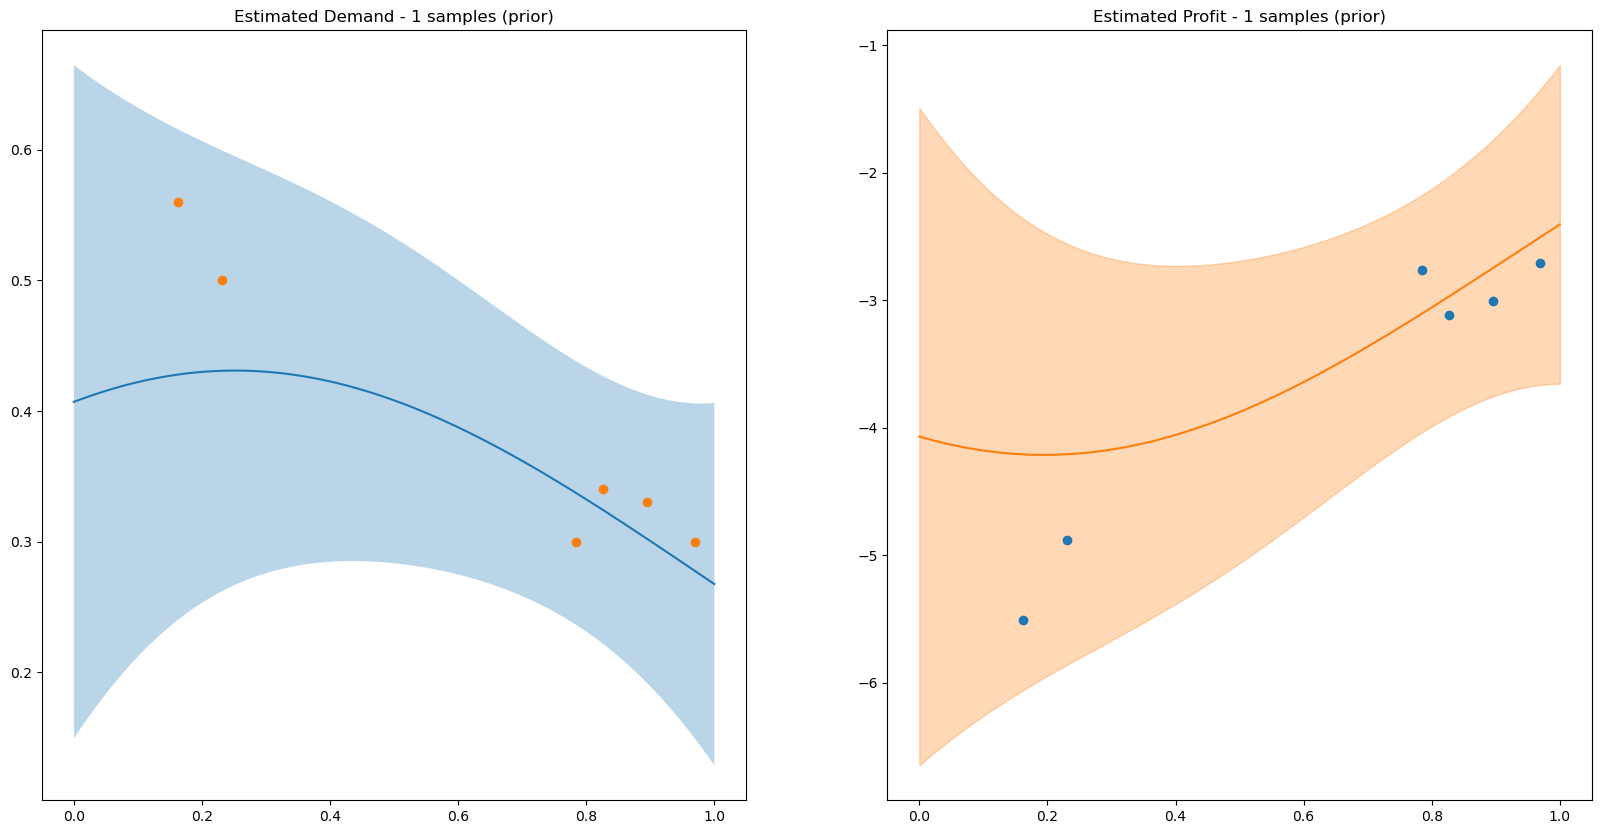

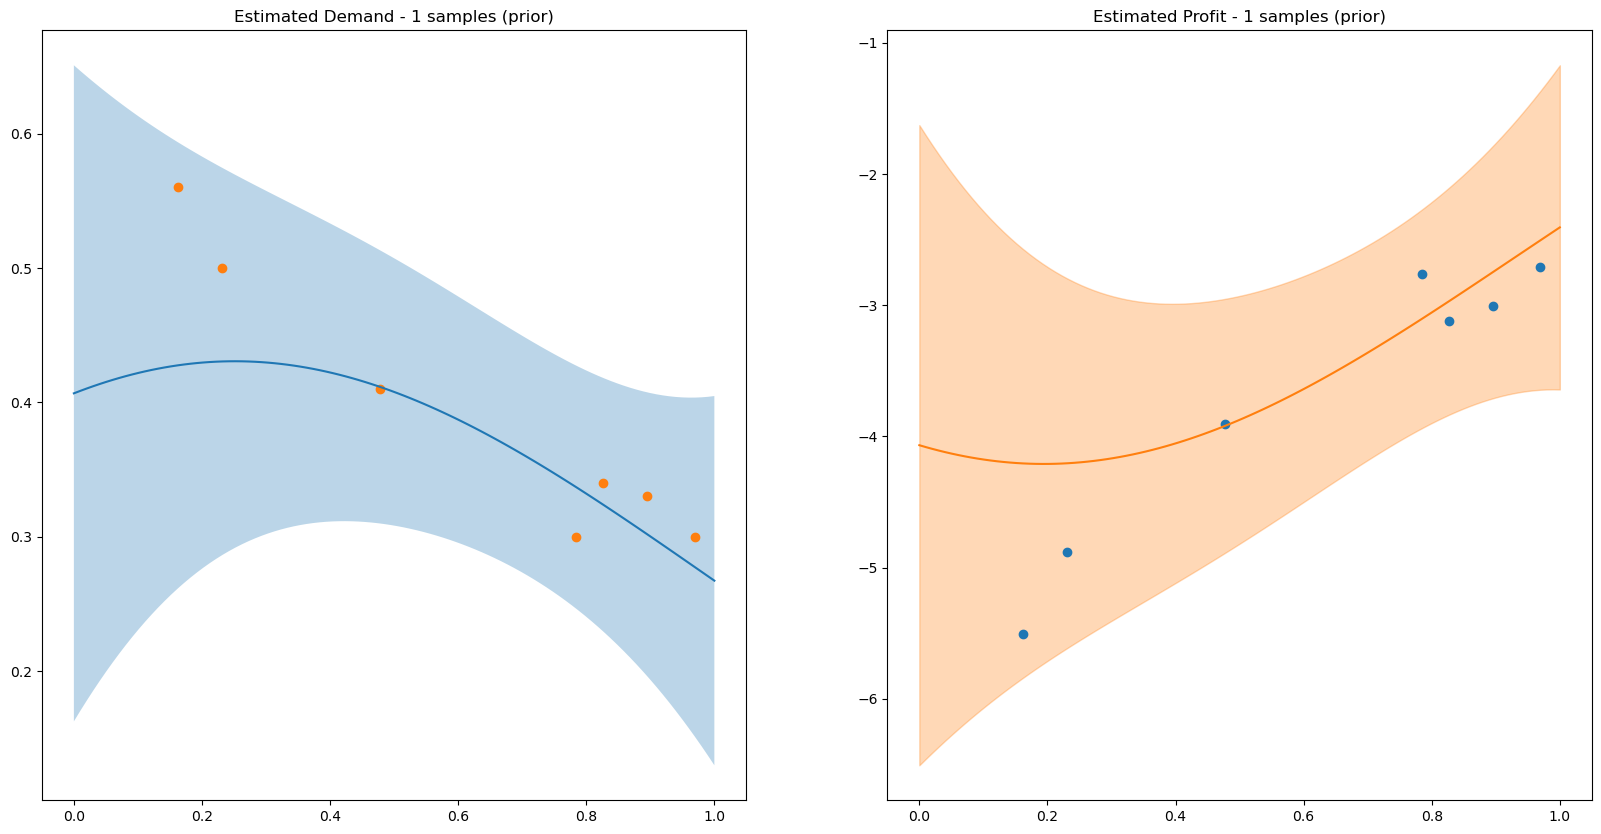

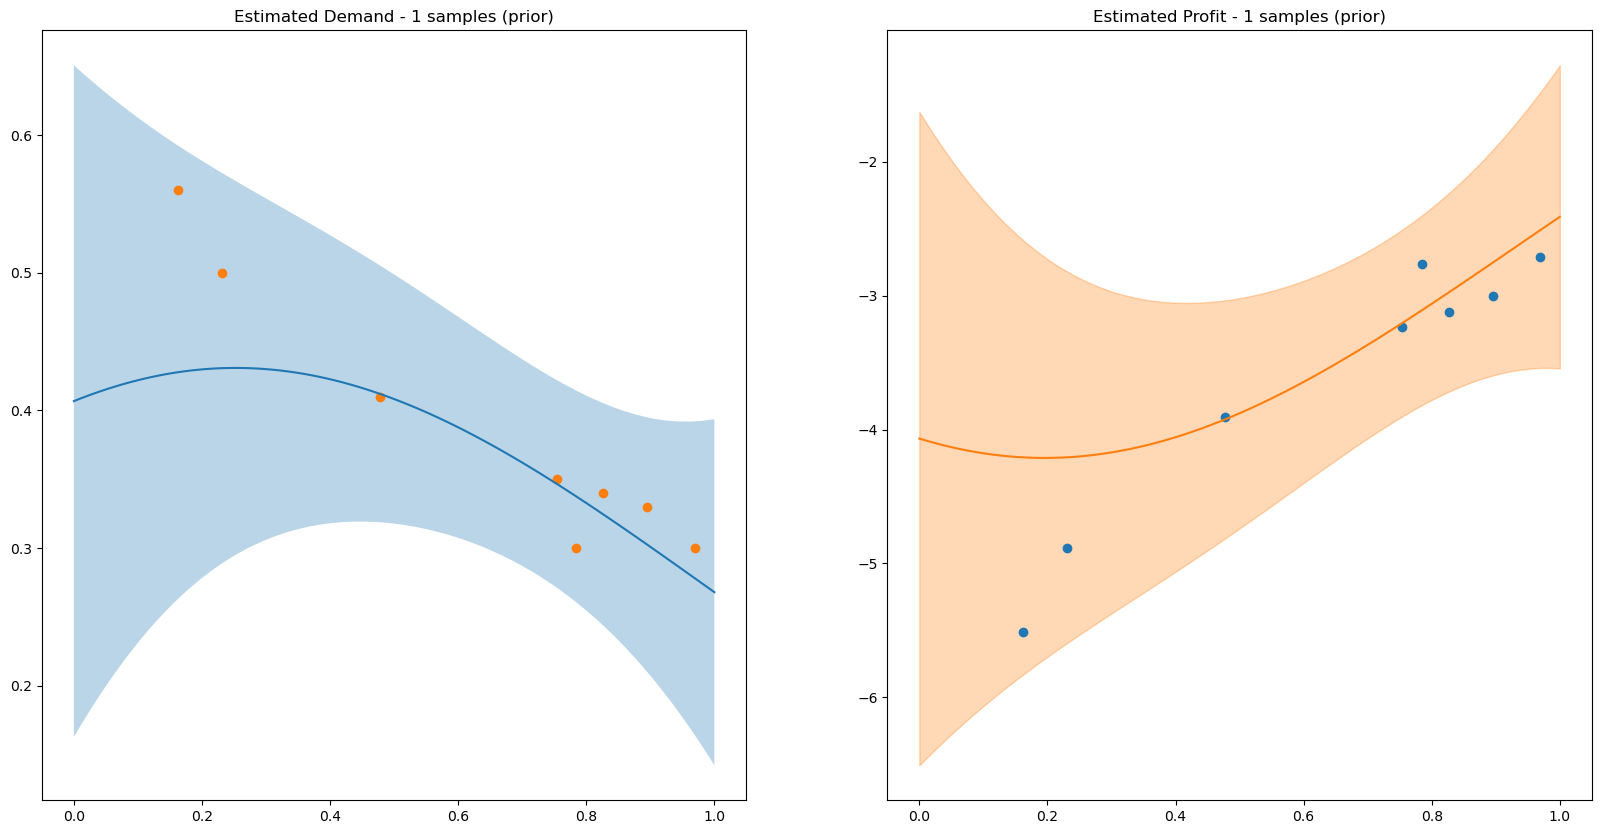

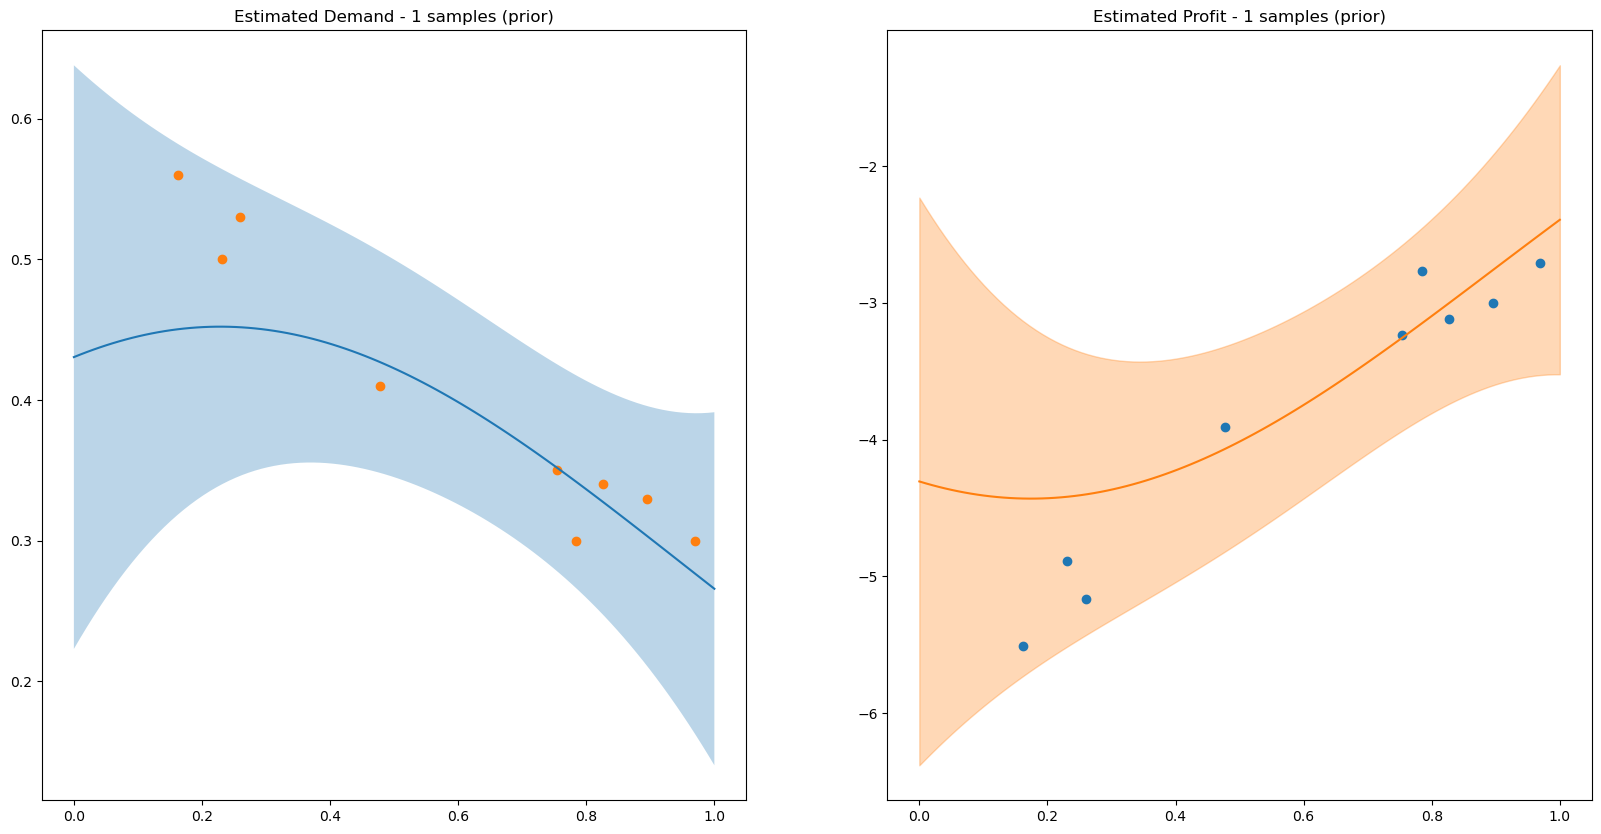

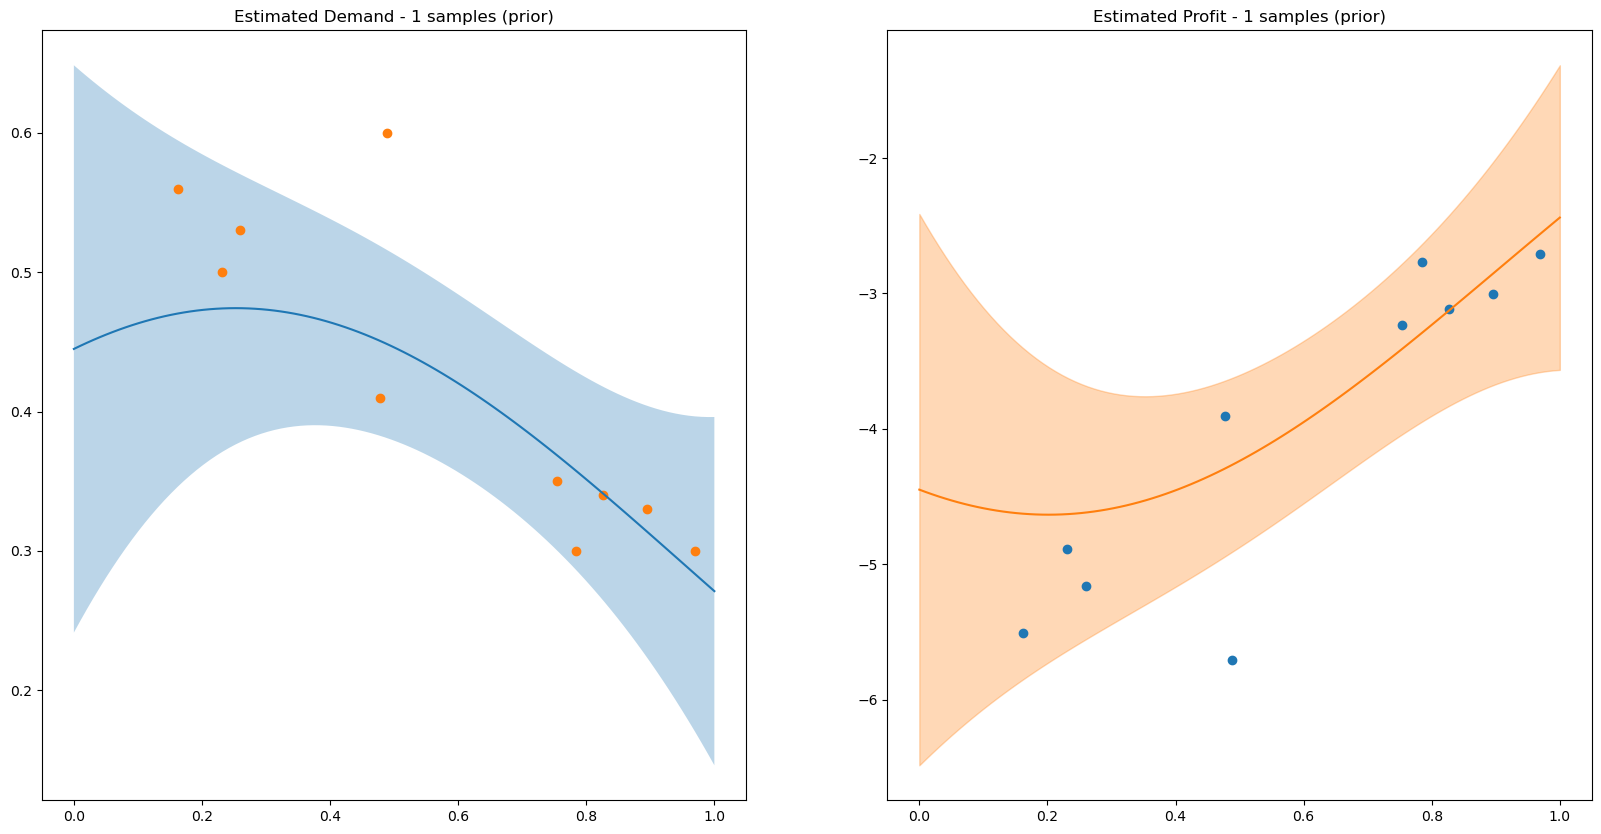

In [132]:
price_samples, normalized_sales_samples =  np.array([]), np.array([])
cost = 10

gp = RBFGaussianProcess(scale=1, reg=0.5).fit()
mu, sigma = gp.predict(PRICES)
profit_mu, profit_sigma = mu*(PRICES-cost), sigma*(PRICES-cost)

f,ax = plt.subplots(1,2, figsize=(20,10))
ax[0].plot(PRICES, mu)
ax[0].fill_between(PRICES, mu-sigma, mu+sigma, alpha=0.3)
ax[0].set_title('Estimated Demand - 0 samples (prior)')
ax[1].plot(PRICES, profit_mu, color='C1')
ax[1].fill_between(PRICES, profit_mu-profit_sigma, profit_mu+profit_sigma, alpha=0.3, color='C1')
ax[1].set_title('Estimated Profit - 0 samples (prior)')
plt.show();

for t in range(10):
    p = np.random.sample()
    s = np.random.binomial(n_customers, conversion_probability(p, t))/n_customers

    price_samples = np.append(price_samples, p)
    normalized_sales_samples = np.append(normalized_sales_samples, s)

    gp.fit(p, s)

    mu, sigma = gp.predict(PRICES)
    profit_mu, profit_sigma = mu*(PRICES-cost), sigma*(PRICES-cost)

    f,ax = plt.subplots(1,2, figsize=(20,10))
    ax[0].plot(PRICES, mu)
    ax[0].fill_between(PRICES, mu-sigma, mu+sigma, alpha=0.3)
    ax[0].set_title(f'Estimated Demand - {_+1} samples (prior)')
    ax[0].scatter(price_samples, normalized_sales_samples)
    ax[1].plot(PRICES, profit_mu, color='C1')
    ax[1].fill_between(PRICES, profit_mu-profit_sigma, profit_mu+profit_sigma, alpha=0.3, color='C1')
    ax[1].set_title(f'Estimated Profit - {_+1} samples (prior)')
    ax[1].scatter(price_samples, normalized_sales_samples*(price_samples-cost))
    plt.show();

### Idea: why don't we choose the price having the large potential profit? -> GP-UCB

## The GP-UCB Algorithm

### GP-UCB uses the Optimism principle just like UCB1. However, UCB1 doesn't consider how rewards from different actions may be related, while GP-UCB does so. The upper confidence bound is computed by summing the average of the GP estimation plus a term which accounts for the estimation uncertainty

In [133]:
# From the agent's point of view, action set is [0,1]. If the actual actions are outside this
# set, we can always perform a rescaling outside the class.
class GPUCBAgent:
    def __init__(self, T, discretization=100):
        self.T = T
        self.arms = np.linspace(0, 1, discretization)
        self.gp = RBFGaussianProcess(scale=2).fit()
        self.a_t = None
        self.action_hist = np.array([])
        self.reward_hist = np.array([])
        self.mu_t = np.zeros(discretization)
        self.sigma_t = np.zeros(discretization)
        # beta is computed from gamma, which represents the maximum information gain at time t
        # gamma grows as log of t (squared), and also exponentially with the dimension of the action space (1 in this case)
        # so if we had three products to choose from, gamma would grow as log(t)^(2*3) = log(t)^6
        # gamma is the pure exploration term, indicating how much exploring could help us
        self.gamma = lambda t: np.log(t+1)**2 
        self.beta = lambda t: 1 + 0.5*np.sqrt(2 * (self.gamma(t) + 1 + np.log(T))) # T involved -> not an anytime algorithm
        self.N_pulls = np.zeros(discretization)
        self.t = 0
    
    def pull_arm(self):
        # sigma is the information we have about the uncertainty of the model, obtained from the GP (and so takes information
        # also from the rewards of the other arms)
        # beta is the exploration parameter, it is obtained from the UCB1 algorithm

        # so in summary this algorithm works a bit like UCB1, but it uses a GP to estimate the rewards of the arms, so it
        # works in a different action space, and it uses the uncertainty of the GP to decide the exploration-exploitation tradeoff
        self.mu_t, self.sigma_t = self.gp.predict(self.arms) 
        ucbs = self.mu_t + self.beta(t) * self.sigma_t
        self.a_t = np.argmax(ucbs)
        return self.arms[self.a_t]
    
    def update(self, r_t):
        self.N_pulls[self.a_t] += 1
        self.action_hist = np.append(self.action_hist, self.arms[self.a_t])
        self.reward_hist = np.append(self.reward_hist, r_t)
        self.gp = self.gp.fit(self.arms[self.a_t], r_t)
        self.t += 1

#### $UCB_t(a) = \mu_{t-1}(a) + \beta_t\sigma_{t-1}(a)$, for $ a\in [0,1]$ (continuous action set).

### $\beta_t$ is the parameter governing exploration. It accounts for two main factors: $\gamma_t$, which represents the maximum information that can be gained at round $t$, and a term in the order of $\mathcal{O}(\sqrt{\log(T)})$ that incentivizes exploration (in a similar way as UCB1).

In [134]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(PRICES), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

agent = GPUCBAgent(T)
env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

# let's compute the clairvoyant
agent_rewards = np.array([])
for t in range(T):
    p_t = agent.pull_arm()
    p_t = rescale(p_t, min_price, max_price)
    d_t, r_t = env.round(p_t, n_t=n_customers, t=t)
    agent.update(r_t/n_customers)
    agent_rewards = np.append(agent_rewards, r_t)

cumulative_regret = np.cumsum(expected_clairvoyant_rewards-agent_rewards)

### Main drawback of this strategy: computational burden!

In [135]:
prices = rescale(agent.action_hist, min_price, max_price)
profits = agent.reward_hist

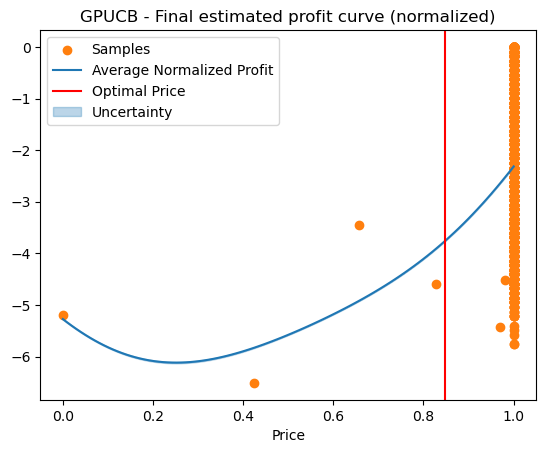

In [139]:
gp = RBFGaussianProcess(scale=2)
gp.fit(prices, profits)
mu, sigma = gp.predict(PRICES)
plt.scatter(prices, profits, label='Samples', color='C1')
plt.plot(PRICES, mu, label='Average Normalized Profit')
plt.axvline(best_price, color='red',label='Optimal Price')
plt.fill_between(PRICES, mu-sigma, mu+sigma, alpha=0.3, label='Uncertainty', color='C0')
plt.title('GPUCB - Final estimated profit curve (normalized)')
plt.xlabel('Price')
plt.legend()
plt.show();

### How's the cumulative regret?

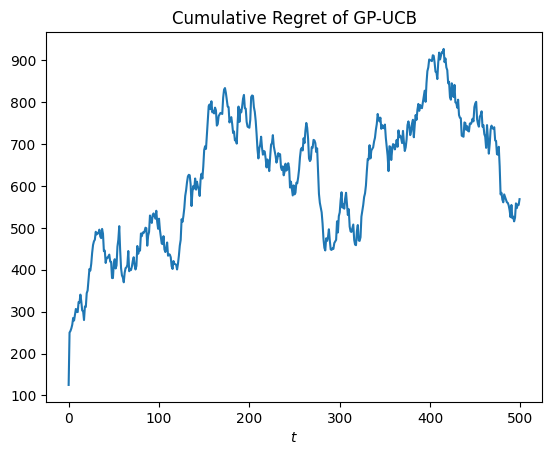

In [ ]:
plt.figure()
plt.plot(cumulative_regret)
plt.title('Cumulative Regret of GP-UCB')
plt.xlabel('$t$')
plt.show();

### Another drawback: instability! Mainly due to Gaussian Processes tendency to overfit.

### The algorithm seems to perform better than a UCB1 strategy with price discretization, but we need a more reliable estimation

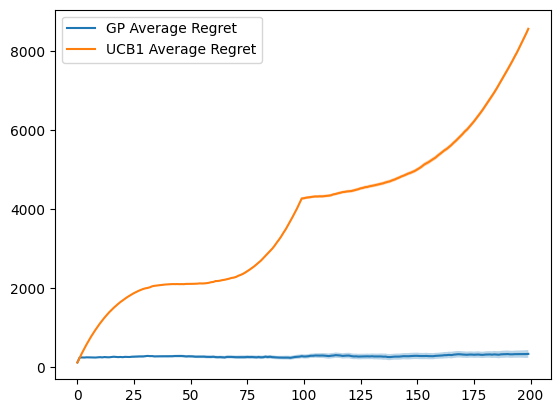

In [ ]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 200
K = 100 # arbitrary discretization

min_price, max_price = 10, 20
n_customers = 100
cost = 10

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 20

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### The performance gap is clear. Why the weird behavior of UCB1's average cumulative regret?

### Note: with $T=200$, UCB1 has to spend half of its time just to try all arms once!

### What would be the discretization prescribed by theory?

In [ ]:
epsilon = T**(-0.33)
K = int(1/epsilon)
K

5

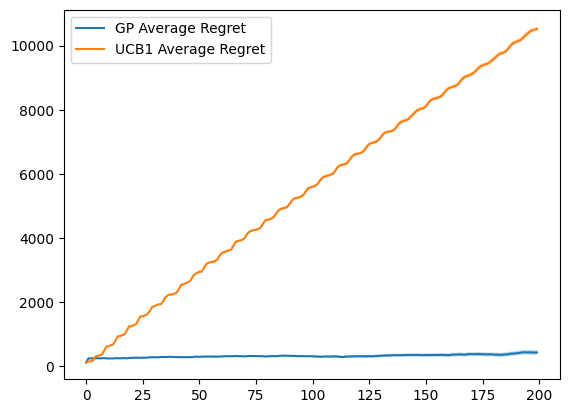

In [ ]:
def rescale(x, min_x, max_x):
    return min_x + (max_x-min_x)*x

conversion_probability = lambda p: 1-p/20
reward_function = lambda price, n_sales: (price-cost)*n_sales
maximum_profit = reward_function(max(prices), n_customers) # the maximum possible reward is selling at the maximum price to every possible customer

T = 200

min_price, max_price = 10, 20
n_customers = 100
cost = 10

# let's compute the clairvoyant
prices = np.linspace(min_price, max_price, K)
profit_curve = reward_function(prices, n_customers*conversion_probability(prices))
best_price_index = np.argmax(profit_curve)
best_price = prices[best_price_index]
expected_clairvoyant_rewards = np.repeat(profit_curve[best_price_index], T)

n_epochs = 20

gp_all_cumulative_regrets = []
ucb_all_cumulative_regrets = []
for i in range(n_epochs):
    gp_agent = GPUCBAgent(T)
    ucb1_agent = UCB1Agent(K, T, range=maximum_profit)

    np.random.seed(10*i)
    env = PricingEnvironment(conversion_probability=conversion_probability, cost=cost)

    gp_agent_rewards = np.array([])
    ucb_agent_rewards = np.array([])
    for t in range(T):
        p_t = gp_agent.pull_arm()
        p_t = rescale(p_t, min_price, max_price)
        d_t, r_t = env.round(p_t, n_t=n_customers)
        gp_agent.update(r_t/n_customers)
        gp_agent_rewards = np.append(gp_agent_rewards, r_t)

        p_t = ucb1_agent.pull_arm()
        p_t = prices[p_t]
        d_t, r_t = env.round(p_t, n_t=n_customers)
        ucb1_agent.update(r_t)
        ucb_agent_rewards = np.append(ucb_agent_rewards, r_t)

    gp_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-gp_agent_rewards))

    ucb_all_cumulative_regrets.append(np.cumsum(expected_clairvoyant_rewards-ucb_agent_rewards))

gp_all_cumulative_regrets = np.array(gp_all_cumulative_regrets)
ucb_all_cumulative_regrets = np.array(ucb_all_cumulative_regrets)

gp_average_cumulative_regret = gp_all_cumulative_regrets.mean(axis=0)
gp_cumulative_regret_std = gp_all_cumulative_regrets.std(axis=0)

ucb_average_cumulative_regret = ucb_all_cumulative_regrets.mean(axis=0)
ucb_cumulative_regret_std = ucb_all_cumulative_regrets.std(axis=0)

plt.plot(np.arange(T), gp_average_cumulative_regret, label='GP Average Regret')
plt.fill_between(np.arange(T),
                gp_average_cumulative_regret-gp_cumulative_regret_std/np.sqrt(n_epochs),
                gp_average_cumulative_regret+gp_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.plot(np.arange(T), ucb_average_cumulative_regret, label='UCB1 Average Regret')
plt.fill_between(np.arange(T),
                ucb_average_cumulative_regret-ucb_cumulative_regret_std/np.sqrt(n_epochs),
                ucb_average_cumulative_regret+ucb_cumulative_regret_std/np.sqrt(n_epochs),
                alpha=0.3)
plt.legend()
plt.show();

### Comparable performances, but this time the regret seems to have at least a sub-linear behavior ($\mathcal{O}(T^\frac{2}{3}\log(T))$).

### Regret of GP-UCB:
### $$ R_T = \mathcal{O}(\sqrt{T}\gamma_T) =  \mathcal{O}(\sqrt{T}\log(T)^{d+1})$$
### where $d$ is the dimension of the action space, in our case $d=1$. Note that the total information gain term scales exponentially with the dimension of the action space -> curse of dimensionality!

### Multi-dimensional action spaces ($d>1$) are very important in dynamic pricing, since they model the scenario in which a seller is offering multiple product, with possibly correlated demands. GP-UCB can be extended to the multi-dimensional scenario, see the reference above.